In [93]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [130]:
device = 'cuda'

In [56]:
dataset_path = kagglehub.dataset_download("sshikamaru/car-object-detection")

In [131]:
%ls dataset_path

 O volume na unidade C nÆo tem nome.
 O N£mero de S‚rie do Volume ‚ 78EE-7442

 Pasta de C:\Users\joao_\Downloads\jupyter-lab\ml-lab\yolo



Arquivo nÆo encontrado


# Dataset

In [57]:
annotations_csv = pd.read_csv(os.path.join(dataset_path, 'data', 'train_solution_bounding_boxes (1).csv'))
annotations_csv

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


In [58]:
annotations = {}
for _, row in annotations_csv.iterrows():
    img_name = row['image']
    
    if img_name not in annotations:
        annotations[img_name] = []
    
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    annotations[img_name].append([xmin, ymin, xmax, ymax])

In [59]:
class CarDetectionDataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform
        self.image_files = list(annotations.keys())

    def __len__(self):
        return len(self.image_files)

    def _convert_to_yolo_format(self, box, img_width, img_height):
        x_center = ((box[0] + box[2]) / 2) / img_width
        y_center = ((box[1] + box[3]) / 2) / img_height
        width = (box[2] - box[0]) / img_width
        height = (box[3] - box[1]) / img_height
        
        return [x_center, y_center, width, height]

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        width, height = image.size

        boxes = self.annotations[img_name]
        yolo_boxes = [self._convert_to_yolo_format(box, width, height) for box in boxes]

        if self.transform:
            image = self.transform(image)

        labels = torch.ones(len(yolo_boxes), dtype=torch.int64)
        
        boxes_tensor = torch.tensor(yolo_boxes, dtype=torch.float32)

        return {
            'image': image,
            'boxes': boxes_tensor,
            'labels': labels,
            'image_id': img_name,
            'orig_size': (width, height)
        }

In [64]:
train_images_dir = os.path.join(dataset_path, 'data', 'training_images')
val_images_dir = os.path.join(dataset_path, 'data', 'testing_images')

transform = transforms.Compose([
    transforms.Resize((416, 416)),  # YOLO typically uses 416x416
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = CarDetectionDataset(train_images_dir, annotations, transform)
val_dataset = CarDetectionDataset(val_images_dir, annotations, transform)

train_loader = DataLoader(
    train_dataset, 
    batch_size=64,
    shuffle=True,
    collate_fn=lambda x: x
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=lambda x: x
)   

Text(0.5, 1.0, 'Image: vid_4_11280.jpg')

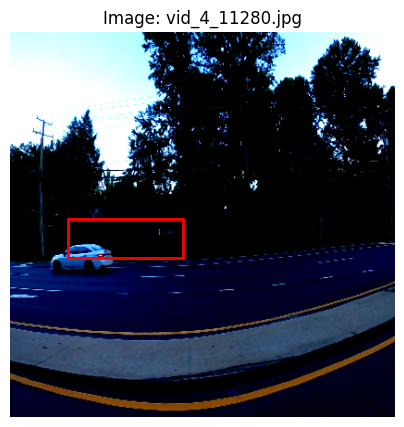

In [91]:
sample = train_dataset[20]
img = sample['image']
boxes = sample['boxes']
orig_size = sample['orig_size']

plt.figure(figsize=(5, 5))

if isinstance(img, torch.Tensor):
    img = img.permute(1, 2, 0).numpy()
    img = (img * 0.5 + 0.5).clip(0, 1)

for box in boxes:
    x_center, y_center, width, height = box

    x_center *= orig_size[0]
    y_center *= orig_size[1]
    width *= orig_size[0]
    height *= orig_size[1]

    xmin = x_center - width/2
    ymin = y_center - height/2

    rect = patches.Rectangle(
        (xmin, ymin), width, height, 
        linewidth=2, edgecolor='r', facecolor='none'
    )
    plt.gca().add_patch(rect)

plt.imshow(img)
plt.axis('off')
plt.title(f"Image: {sample['image_id']}")

# Model

In [95]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(ConvBlock, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        return F.leaky_relu(self.bn(self.conv(x)), 0.1)

In [117]:
class TinyYOLO(nn.Module):
    def __init__(self, num_classes=1, num_boxes=1):
        super(TinyYOLO, self).__init__()

        self.box_values = 5 # x, y, w, h, confidence
        self.num_classes = num_classes
        self.num_boxes = num_boxes

        self.features = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=16),
            nn.MaxPool2d(2, 2),

            ConvBlock(in_channels=16, out_channels=32),
            nn.MaxPool2d(2, 2),

            ConvBlock(in_channels=32, out_channels=64),
            nn.MaxPool2d(2, 2),
            
            ConvBlock(in_channels=64, out_channels=128),
            nn.MaxPool2d(2, 2),
            
            ConvBlock(in_channels=128, out_channels=256),
            nn.MaxPool2d(2, 2),
        )

        # detection head (final layer)
        # for each grid cell, predict num_boxes boxes, each with box_values + num_classes values
        # output shape: (batch_size, num_boxes * (box_values + num_classes), grid_h, grid_w)
        self.detection = nn.Conv2d(
            256, 
            self.num_boxes * (self.box_values + self.num_classes),
            kernel_size=1
        )

    def forward(self, x):
        features = self.features(x)
        detection = self.detection(features)

        batch_size = detection.size(0)
        grid_size = detection.size(2)

        detection = detection.view(
            batch_size,
            self.num_boxes,
            self.box_values + self.num_classes,
            grid_size,
            grid_size
        ).permute(0, 1, 3, 4, 2).contiguous()

        return detection

    def predict(self, x):
        device = x.device
        batch_size = x.size(0)
        predictions = self.forward(x)
        grid_size = predictions.size(2)
        
        grid_x = torch.arange(grid_size, device=device).repeat(grid_size, 1).view([1, 1, grid_size, grid_size])
        grid_y = torch.arange(grid_size, device=device).repeat(grid_size, 1).t().view([1, 1, grid_size, grid_size])

        pred_boxes = torch.zeros_like(predictions)

        pred_boxes[..., 0] = torch.sigmoid(predictions[..., 0]) + grid_x.float()  # x center
        pred_boxes[..., 1] = torch.sigmoid(predictions[..., 1]) + grid_y.float()  # y center
        pred_boxes[..., 2] = torch.exp(predictions[..., 2])  # width
        pred_boxes[..., 3] = torch.exp(predictions[..., 3])  # height
        pred_boxes[..., 4] = torch.sigmoid(predictions[..., 4]) # confidence

        if self.num_classes > 1:
            pred_boxes[..., 5:] = torch.softmax(predictions[..., 5:], dim=-1)
        else:
            pred_boxes[..., 5] = torch.sigmoid(predictions[..., 5])

        pred_boxes[..., :4] /= grid_size

        return pred_boxes

In [123]:
class YOLOLoss(nn.Module):
    def __init__(self, lambda_coord=5.0, lambda_noobj=0.5):
        super(YOLOLoss, self).__init__()
        self.mse = nn.MSELoss(reduction='sum')
        self.bce = nn.BCEWithLogitsLoss(reduction='sum')
        self.lambda_coord = lambda_coord  # weight for coordinate predictions
        self.lambda_noobj = lambda_noobj  # weight for no-object confidence
    
    def forward(self, predictions, targets, grid_size=13):
        batch_size = predictions.size(0)
        
        obj_mask = targets[..., 4] > 0.5
        noobj_mask = targets[..., 4] < 0.5
        
        # === COORDINATE LOSS ===
        if obj_mask.sum() > 0:
            xy_loss = self.mse(
                predictions[..., :2][obj_mask], 
                targets[..., :2][obj_mask]
            )
            
            wh_loss = self.mse(
                predictions[..., 2:4][obj_mask], 
                targets[..., 2:4][obj_mask]
            )
        else:
            xy_loss = 0
            wh_loss = 0
        
        # === CONFIDENCE LOSS ===
        if obj_mask.sum() > 0:
            conf_obj_loss = self.bce(
                predictions[..., 4][obj_mask], 
                targets[..., 4][obj_mask]
            )
        else:
            conf_obj_loss = 0
            
        if noobj_mask.sum() > 0:
            conf_noobj_loss = self.bce(
                predictions[..., 4][noobj_mask], 
                targets[..., 4][noobj_mask]
            )
        else:
            conf_noobj_loss = 0
        
        # === CLASSIFICATION LOSS ===
        if obj_mask.sum() > 0:
            class_loss = self.bce(
                predictions[..., 5:][obj_mask], 
                targets[..., 5:][obj_mask]
            )
        else:
            class_loss = 0
        
        # combine all losses with appropriate weights
        total_loss = (
            self.lambda_coord * (xy_loss + wh_loss) + 
            conf_obj_loss + 
            self.lambda_noobj * conf_noobj_loss + 
            class_loss
        ) / batch_size
        
        return total_loss

In [136]:
def create_target_tensor(boxes, grid_size=13, num_boxes=2, num_classes=1):
    target = torch.zeros(num_boxes, grid_size, grid_size, 5 + num_classes)
    
    for box in boxes:
        x_center, y_center, width, height = box
        
        # scale to grid size
        grid_x = int(x_center * grid_size)
        grid_y = int(y_center * grid_size)
        
        # ensure grid indices are within bounds
        grid_x = min(grid_x, grid_size - 1)
        grid_y = min(grid_y, grid_size - 1)
        
        box_idx = 0
        
        target[box_idx, grid_y, grid_x, 0] = x_center * grid_size - grid_x  # x offset within cell
        target[box_idx, grid_y, grid_x, 1] = y_center * grid_size - grid_y  # y offset within cell
        target[box_idx, grid_y, grid_x, 2] = width  # width (normalized)
        target[box_idx, grid_y, grid_x, 3] = height  # height (normalized)
        target[box_idx, grid_y, grid_x, 4] = 1.0  # objectness score
        target[box_idx, grid_y, grid_x, 5] = 1.0  # class probability (just "car" in our case)
    
    return target

def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch in val_loader:
            # Similar processing as in training
            batch_images = []
            batch_targets = []
            
            for sample in batch:
                image = sample['image'].to(device)
                boxes = sample['boxes']
                
                target = create_target_tensor(
                    boxes, 
                    grid_size=13, 
                    num_boxes=model.num_boxes, 
                    num_classes=model.num_classes
                ).to(device)
                
                batch_images.append(image)
                batch_targets.append(target)
            
            images = torch.stack(batch_images)
            targets = torch.stack(batch_targets)
            
            # Forward pass
            predictions = model(images)
            
            # Calculate loss
            loss = criterion(predictions, targets)
            val_loss += loss.item()
    
    return val_loss / len(val_loader)

def train_model(model, train_loader, val_loader=None, epochs=50, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = YOLOLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=5, verbose=True
    )

    history = {
        'train_loss': [],
    }
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, batch in enumerate(train_loader):
            batch_images = []
            batch_targets = []

            for sample in batch:
                image = sample['image'].to(device)
                boxes = sample['boxes']

                target = create_target_tensor(
                    boxes, 
                    grid_size=13, 
                    num_boxes=model.num_boxes, 
                    num_classes=model.num_classes
                ).to(device)

                batch_images.append(image)
                batch_targets.append(target)

            images = torch.stack(batch_images)
            targets = torch.stack(batch_targets)

            optimizer.zero_grad()
            predictions = model(images)
            loss = criterion(predictions, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_loss)

        print(f"Epoch {epoch+1}/{epochs} completed, Avg Loss: {epoch_loss:.4f}")

        # if val_loader:
        #     val_loss = validate_model(model, val_loader, criterion, device)
        #     history['val_loss'].append(val_loss)
            
        #     # Update learning rate based on validation loss
        #     scheduler.step(val_loss)
            
        #     print(f"Validation Loss: {val_loss:.4f}")

    torch.save(model.state_dict(), "yolo_car_detector.pt")
    return model, history

In [137]:
model = TinyYOLO(num_classes=1, num_boxes=1)
model

TinyYOLO(
  (features): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ConvBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)

In [138]:
model, history = train_model(
    model, 
    train_loader, 
    val_loader=None,
    epochs=50, 
    learning_rate=0.001
)

Epoch 1/50 completed, Avg Loss: 85.0685
Epoch 2/50 completed, Avg Loss: 32.4026
Epoch 3/50 completed, Avg Loss: 18.7253
Epoch 4/50 completed, Avg Loss: 12.5991
Epoch 5/50 completed, Avg Loss: 9.3524
Epoch 6/50 completed, Avg Loss: 7.6204
Epoch 7/50 completed, Avg Loss: 6.4552
Epoch 8/50 completed, Avg Loss: 5.5980
Epoch 9/50 completed, Avg Loss: 5.0199
Epoch 10/50 completed, Avg Loss: 4.5012
Epoch 11/50 completed, Avg Loss: 4.0953
Epoch 12/50 completed, Avg Loss: 3.7115
Epoch 13/50 completed, Avg Loss: 3.3654
Epoch 14/50 completed, Avg Loss: 3.1350
Epoch 15/50 completed, Avg Loss: 2.9169
Epoch 16/50 completed, Avg Loss: 2.6896
Epoch 17/50 completed, Avg Loss: 2.5067
Epoch 18/50 completed, Avg Loss: 2.3026
Epoch 19/50 completed, Avg Loss: 2.1829
Epoch 20/50 completed, Avg Loss: 2.0806
Epoch 21/50 completed, Avg Loss: 1.9087
Epoch 22/50 completed, Avg Loss: 1.8061
Epoch 23/50 completed, Avg Loss: 1.6871
Epoch 24/50 completed, Avg Loss: 1.6672
Epoch 25/50 completed, Avg Loss: 1.5682
Epoch

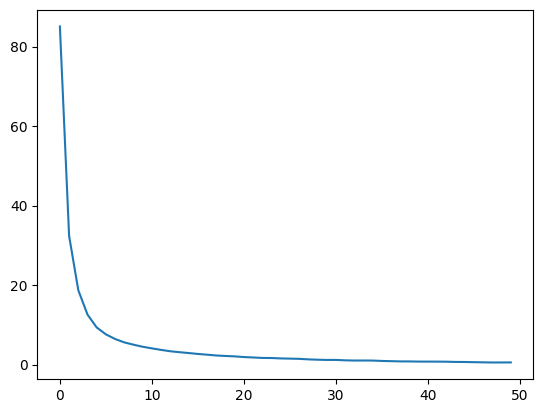

In [139]:
plt.plot(history["train_loss"])

In [150]:
def detect_cars(model, image_path, confidence_threshold=0.25, iou_threshold=0.5):
    model.eval()
    device = next(model.parameters()).device

    image = Image.open(image_path).convert('RGB')
    orig_width, orig_height = image.size

    transform = transforms.Compose([
        transforms.Resize((416, 416)),  # Resize to model input size
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model.predict(img_tensor)

    detections = []
    pred = predictions[0]

    for box_idx in range(pred.size(0)):
        for cell_y in range(pred.size(1)):
            for cell_x in range(pred.size(2)):
                confidence = pred[box_idx, cell_y, cell_x, 4]
                class_conf = pred[box_idx, cell_y, cell_x, 5]
                
                # Filter by confidence
                if confidence > confidence_threshold:
                    # Extract box coordinates
                    x_center = pred[box_idx, cell_y, cell_x, 0]
                    y_center = pred[box_idx, cell_y, cell_x, 1]
                    width = pred[box_idx, cell_y, cell_x, 2]
                    height = pred[box_idx, cell_y, cell_x, 3]
                    
                    # Convert to corner coordinates
                    x1 = (x_center - width/2)
                    y1 = (y_center - height/2)
                    x2 = (x_center + width/2)
                    y2 = (y_center + height/2)
                    
                    # Scale back to original image
                    x1 *= orig_width
                    y1 *= orig_height
                    x2 *= orig_width
                    y2 *= orig_height
                    
                    # Add detection
                    detections.append([x1, y1, x2, y2, confidence * class_conf])
    detected_boxes = non_maximum_suppression(detections, iou_threshold)

    return detected_boxes, image

def non_maximum_suppression(boxes, iou_threshold):
    if not boxes:
        return []
    
    # Ensure all values are native Python types
    boxes_python = []
    for box in boxes:
        box_python = []
        for val in box:
            # Handle if the value is a tensor
            if isinstance(val, torch.Tensor):
                box_python.append(float(val.cpu().item()))
            else:
                box_python.append(float(val))
        boxes_python.append(box_python)
    
    # Convert to numpy array for easier operations
    boxes = np.array(boxes_python)
    
    # Extract coordinates and confidence
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    scores = boxes[:, 4]
    
    # Calculate area of each box
    areas = (x2 - x1) * (y2 - y1)
    
    # Sort by confidence (descending)
    order = scores.argsort()[::-1]
    
    keep = []
    while order.size > 0:
        # Pick the box with highest confidence
        i = order[0]
        keep.append(i)
        
        # Calculate IoU with remaining boxes
        if order.size == 1:
            break
            
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        
        # Intersection area
        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        intersection = w * h
        
        # IoU = intersection / union
        iou = intersection / (areas[i] + areas[order[1:]] - intersection)
        
        # Keep boxes with IoU less than threshold
        inds = np.where(iou <= iou_threshold)[0]
        order = order[inds + 1]
    
    return boxes[keep].tolist()

def visualize_detections(image, boxes, output_path=None):
    # Convert PIL image to numpy array if needed
    if isinstance(image, Image.Image):
        image_np = np.array(image)
    else:
        image_np = image
    
    # Create figure and axis
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)
    
    # Add bounding boxes
    for box in boxes:
        x1, y1, x2, y2, conf = box
        
        # Create rectangle patch
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        
        # Add the rectangle to the plot
        plt.gca().add_patch(rect)
        
        # Add confidence label
        plt.text(
            x1, y1 - 10, f'Car: {conf:.2f}',
            color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.7)
        )
    
    plt.axis('off')
    
    # Save or display
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
    else:
        plt.show()
    
    plt.close()

In [217]:
imgs = [
    r"C:\Users\joao_\Downloads\images (2).jpg",
    r"C:\Users\joao_\Downloads\640px-White-tailed_deer.jpg",
    r"C:\Users\joao_\Downloads\images (5).jpg",
    r"C:\Users\joao_\Downloads\images (6).jpg"
]

outs = []

for i in imgs:
    boxes, image = detect_cars(model, i, confidence_threshold=0.5)
    outs.append((boxes, image))

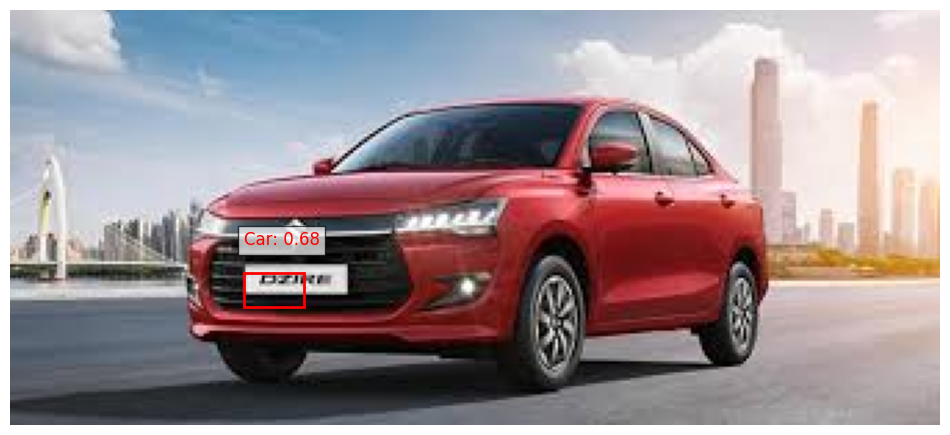

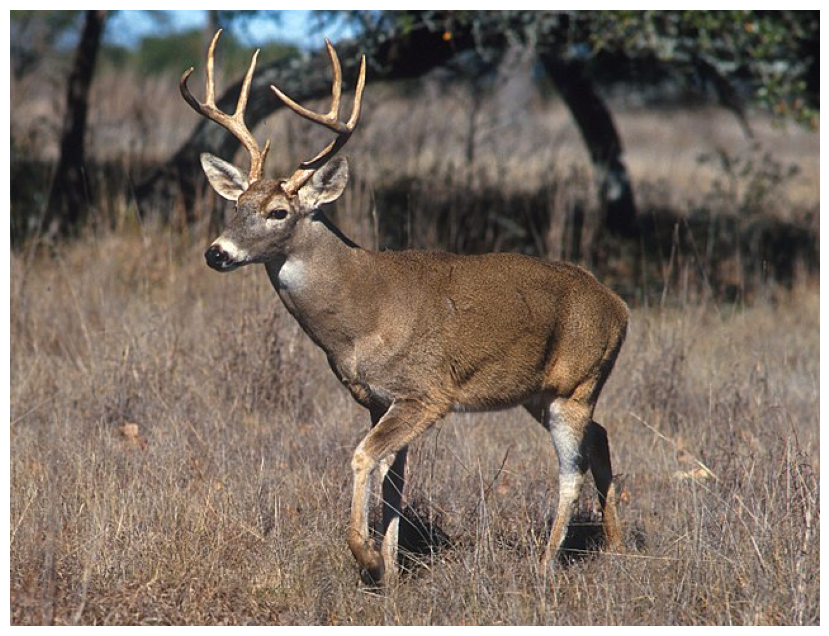

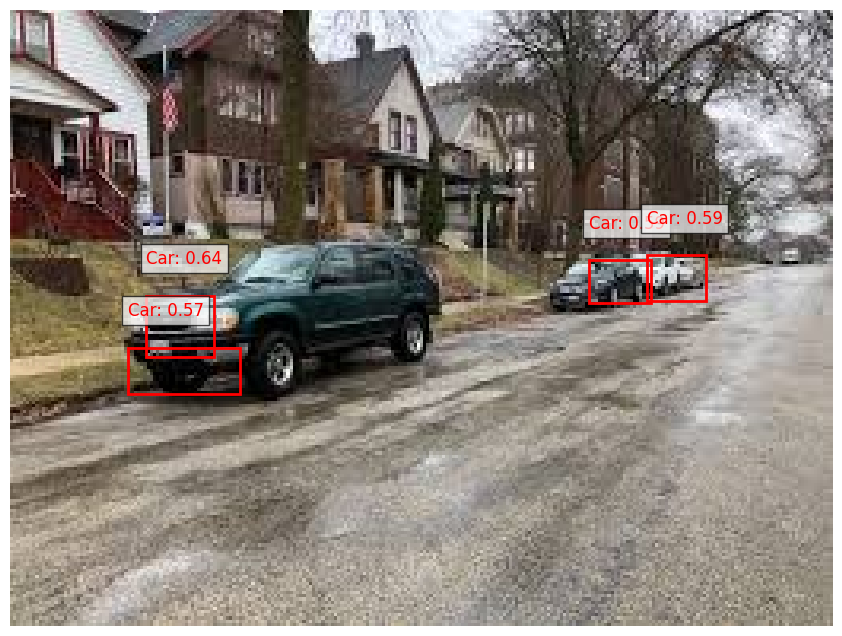

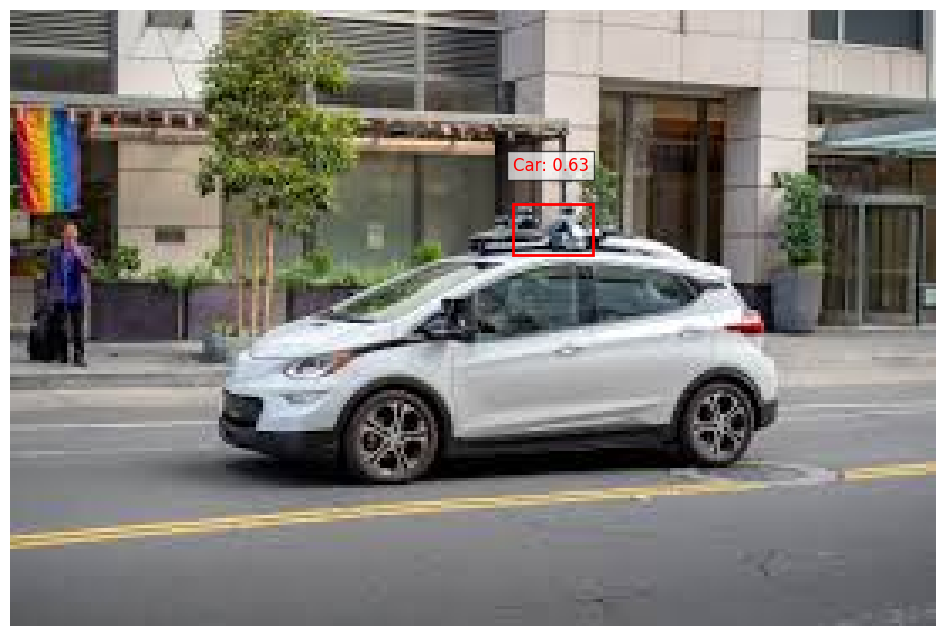

In [218]:
for (b, i) in outs:
    visualize_detections(i, b)